In [1]:
from transformers import AutoProcessor, AutoModelForImageTextToText,AutoModelForCausalLM,AutoTokenizer
from transformers.image_utils import load_image
from transformers import AutoTokenizer
from PIL import Image
import torch

In [2]:
import json

In [3]:
# Load model and processor
model_id_vlm = "LiquidAI/LFM2-VL-450M"
model_vlm = AutoModelForImageTextToText.from_pretrained(
    model_id_vlm,
    device_map={"": "cpu"},  # force CPU
    torch_dtype="float32",   # safer on CPU
    trust_remote_code=True
)
processor_vlm = AutoProcessor.from_pretrained(model_id_vlm, trust_remote_code=True)

# ===== LOAD TEST IMAGE =====
# image_path = "./detected/003843_detections.jpg"
image_path = "data/final-horizontal.jpg"
image = Image.open(image_path)
if image.mode != "RGB":
    image = image.convert("RGB")

# image = image.resize((256, 256), Image.LANCZOS)
image = image.resize((512, 512), Image.LANCZOS)
# image = image.resize((384, 680), Image.LANCZOS)
# image = image.resize((1000, 3000), Image.LANCZOS)


# Load model and processor
model_id_llm = "LiquidAI/LFM2-350M"
model_llm = AutoModelForCausalLM.from_pretrained(
    model_id_llm,
    device_map="auto",
    torch_dtype="bfloat16",
    trust_remote_code=True
)
tokenizer_vlm = AutoTokenizer.from_pretrained(model_id_llm)

conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {
                "type": "text",
                "text": """You are an expert gauge inspector. Carefully analyze the provided image and extract readings for these three devices: thermometer, pressure_gauge, and rain_gauge.

OUTPUT RULES (must follow exactly):
1. Return ONLY a single VALID JSON object and NOTHING ELSE (no explanation, no markdown, no backticks).
2. The JSON must match this schema exactly:
{
  "thermometer": <number|null>,
  "pressure_gauge": <number|null>,
  "rain_gauge": <number|null>
}
3. Use numeric types for values (e.g., 23.5) or null when the gauge is not present or unreadable.
4. Round numeric values to at most two decimal places. If exact integer, return integer (e.g., 12).
5. Do not include units, extra keys, or commentary.

Now analyze the attached image and produce the single JSON object described above."""
            },
        ],
    },
]


# Generate Answer
inputs = processor_vlm.apply_chat_template(
    conversation,
    add_generation_prompt=True,
    return_tensors="pt",
    return_dict=True,
    tokenize=True,
).to(model_vlm.device)


outputs = model_vlm.generate(**inputs, max_new_tokens=512)
decoded = processor_vlm.batch_decode(outputs, skip_special_tokens=True)[0]

# Extract only the assistant's reply
if "assistant" in decoded:
    response = decoded.split("assistant", 1)[1].strip()
else:
    response = decoded.strip()

print("\n--- Model Response ---")
print(response)

`torch_dtype` is deprecated! Use `dtype` instead!


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]


--- Model Response ---
{
  "thermometer": 123.56,
  "pressure_gauge": 45.56,
  "rain_gauge": 107.56
}


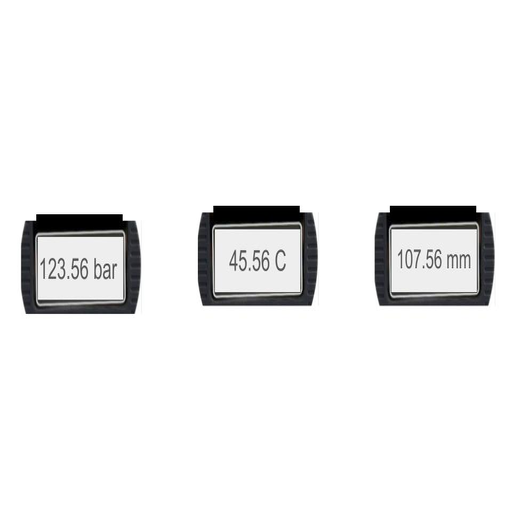

In [4]:
image

In [28]:
import sqlite3
import json
from datetime import datetime

# Example JSON response
response = """
{
  "thermometer": 129.56,
  "pressure_gauge": 48.56,
  "rain_gauge": 70.56
}
"""

# Parse JSON
data = json.loads(response)

# Extract values
temperature = float(data["thermometer"])
pressure = float(data["pressure_gauge"])
rain = float(data["rain_gauge"])

# Current timestamp
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Connect to (or create) a SQLite DB
conn = sqlite3.connect("sensors-json.db")
cursor = conn.cursor()

# Create table if not exists
cursor.execute("""
CREATE TABLE IF NOT EXISTS sensor_data (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    timestamp TEXT,
    temperature REAL,
    pressure REAL,
    rain REAL
)
""")

# Insert the parsed values
cursor.execute("""
INSERT INTO sensor_data (timestamp, temperature, pressure, rain)
VALUES (?, ?, ?, ?)
""", (timestamp, temperature, pressure, rain))

# Commit and close
conn.commit()
conn.close()


In [29]:
import sqlite3

# Connect to the same database
conn = sqlite3.connect("sensors-json.db")
cursor = conn.cursor()

# Query all rows
cursor.execute("SELECT * FROM sensor_data")
rows = cursor.fetchall()

# Print nicely
for row in rows:
    print(row)

conn.close()


(1, '2025-09-14 11:31:15', 123.56, 45.56, 107.56)
(2, '2025-09-14 11:33:31', 125.56, 46.56, 108.56)
(3, '2025-09-14 11:33:43', 129.56, 48.56, 110.56)
(4, '2025-09-14 11:37:04', 129.56, 48.56, 70.56)


In [30]:
import sqlite3
import pandas as pd

# Connect to the database
conn = sqlite3.connect("sensors-json.db")

# Load the whole table into a DataFrame
df = pd.read_sql_query("SELECT * FROM sensor_data", conn)

# Close the connection
conn.close()

# Display the DataFrame
print(df)


   id            timestamp  temperature  pressure    rain
0   1  2025-09-14 11:31:15       123.56     45.56  107.56
1   2  2025-09-14 11:33:31       125.56     46.56  108.56
2   3  2025-09-14 11:33:43       129.56     48.56  110.56
3   4  2025-09-14 11:37:04       129.56     48.56   70.56


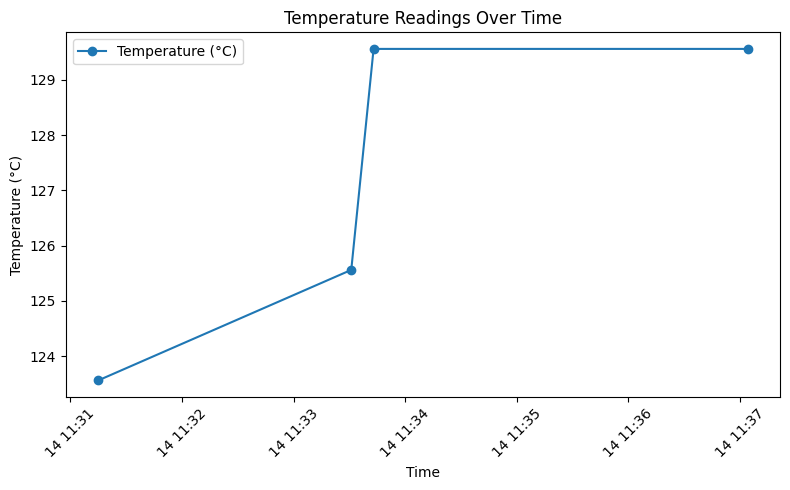

In [31]:
import sqlite3
import matplotlib.pyplot as plt
from datetime import datetime

# Connect to DB
conn = sqlite3.connect("sensors-json.db")
cursor = conn.cursor()

# Fetch timestamps and temperatures
cursor.execute("SELECT timestamp, temperature FROM sensor_data ORDER BY id ASC")
rows = cursor.fetchall()
conn.close()

# Separate into lists
timestamps = [datetime.strptime(r[0], "%Y-%m-%d %H:%M:%S") for r in rows]
temperatures = [r[1] for r in rows]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(timestamps, temperatures, marker="o", linestyle="-", label="Temperature (°C)")

plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.title("Temperature Readings Over Time")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


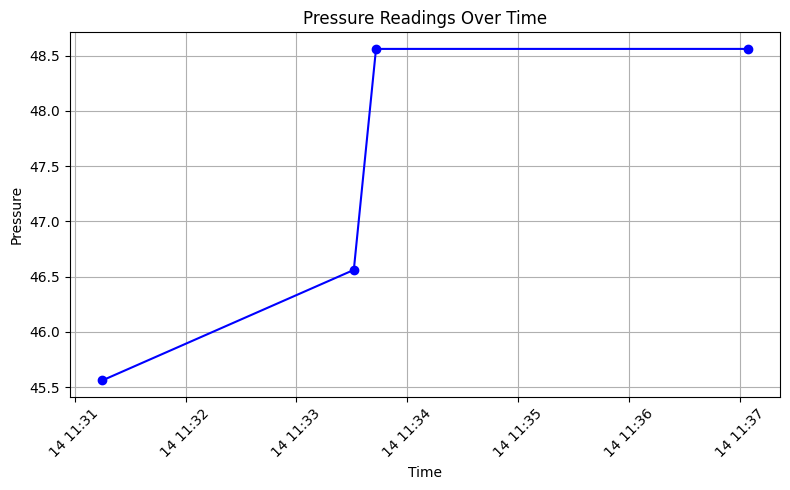

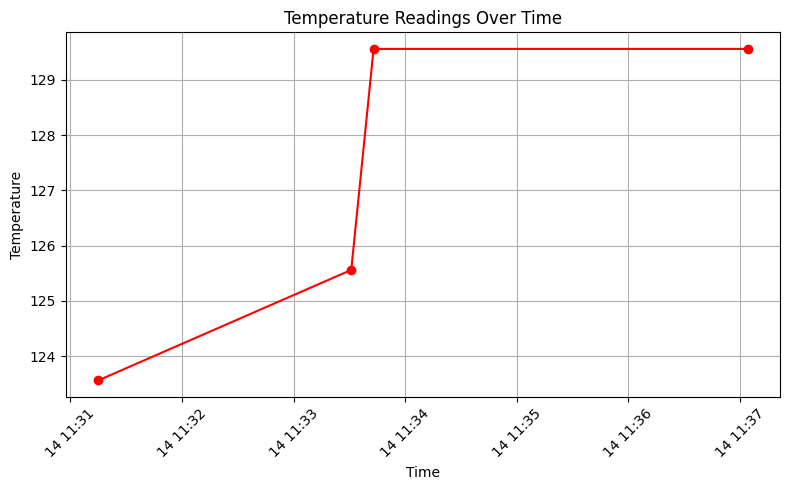

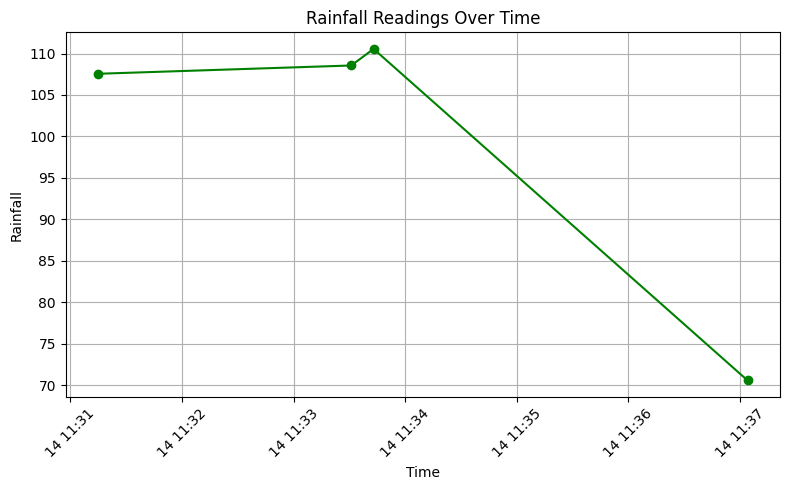

In [32]:
import sqlite3
import matplotlib.pyplot as plt
from datetime import datetime

# Connect to DB
conn = sqlite3.connect("sensors-json.db")
cursor = conn.cursor()

# Fetch all sensor data (timestamp, pressure, temperature, rain)
cursor.execute("""
    SELECT timestamp, pressure, temperature, rain FROM sensor_data ORDER BY id ASC
""")
rows = cursor.fetchall()
conn.close()

# Separate into lists
timestamps = [datetime.strptime(r[0], "%Y-%m-%d %H:%M:%S") for r in rows]
pressures = [r[1] for r in rows]
temperatures = [r[2] for r in rows]
rains = [r[3] for r in rows]

# Plot Pressure
plt.figure(figsize=(8, 5))
plt.plot(timestamps, pressures, marker="o", linestyle="-", color="blue", label="Pressure")
plt.xlabel("Time")
plt.ylabel("Pressure")
plt.title("Pressure Readings Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Temperature
plt.figure(figsize=(8, 5))
plt.plot(timestamps, temperatures, marker="o", linestyle="-", color="red", label="Temperature")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.title("Temperature Readings Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Rainfall
plt.figure(figsize=(8, 5))
plt.plot(timestamps, rains, marker="o", linestyle="-", color="green", label="Rainfall")
plt.xlabel("Time")
plt.ylabel("Rainfall")
plt.title("Rainfall Readings Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [33]:
import sqlite3
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from datetime import datetime

DB_PATH = "sensors.db"

def fetch_data():
    """Fetch all timestamps and temperature values from DB."""
    conn = sqlite3.connect(DB_PATH)
    cursor = conn.cursor()
    cursor.execute("SELECT timestamp, temperature FROM sensor_data ORDER BY id ASC")
    rows = cursor.fetchall()
    conn.close()
    return rows

def animate(frame):
    rows = fetch_data()
    if not rows:
        return
    
    # Extract data
    timestamps = [datetime.strptime(r[0], "%Y-%m-%d %H:%M:%S") for r in rows]
    temperatures = [r[1] for r in rows]

    # Clear old plot
    plt.cla()
    plt.plot(timestamps, temperatures, marker="o", linestyle="-", label="Temperature (°C)")
    plt.xlabel("Time")
    plt.ylabel("Temperature (°C)")
    plt.title("Live Temperature Readings")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()

# Setup figure
fig = plt.figure(figsize=(8, 5))

# Run animation (update every 2 seconds)
ani = animation.FuncAnimation(fig, animate, interval=2000)

plt.show()

/var/folders/bw/zwn916250j389j86x0z9f6tr0000gn/T/ipykernel_62477/3171332155.py:40: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = animation.FuncAnimation(fig, animate, interval=2000)


<Figure size 800x500 with 0 Axes>

In [34]:
def turn_on_light(room: str):
    return {"status": f"Light in {room} turned ON"}

def turn_off_light(room: str):
    return {"status": f"Light in {room} turned OFF"}

In [35]:
# Map function names to actual implementations
TOOLS = {
    "turn_on_light": turn_on_light,
    "turn_off_light": turn_off_light
}

In [36]:
# --------------------------
# Define tools JSON for LFM2
# --------------------------
tools_json = [
    {
        "name": "turn_on_light",
        "description": "Turn on the light in a specified room",
        "parameters": {
            "type": "object",
            "properties": {
                "room": {"type": "string", "description": "Name of the room"}
            },
            "required": ["room"]
        }
    },
    {
        "name": "turn_off_light",
        "description": "Turn off the light in a specified room",
        "parameters": {
            "type": "object",
            "properties": {
                "room": {"type": "string", "description": "Name of the room"}
            },
            "required": ["room"]
        }
    }
]

In [37]:
response

'\n{\n  "thermometer": 129.56,\n  "pressure_gauge": 48.56,\n  "rain_gauge": 70.56\n}\n'

In [38]:
meter_reading = response

In [39]:
meter_reading

'\n{\n  "thermometer": 129.56,\n  "pressure_gauge": 48.56,\n  "rain_gauge": 70.56\n}\n'

In [40]:
# prompt = f"""
# <|startoftext|><|im_start|>system
# List of tools: <|tool_list_start|>{json.dumps(tools_json)}<|tool_list_end|><|im_end|>
# <|im_start|>user
# The meter reading is {meter_reading} mm.
# If the reading is greater than 80 mm, call turn_off_light with room="living_room".
# If it is 80 or less, do nothing.
# <|im_end|>
# <|im_start|>assistant
# """

In [32]:
# prompt = f"""
# <|startoftext|><|im_start|>system
# You are a controller that must decide whether to call a tool.
# Always respond ONLY with a valid tool call in JSON format.
# Do not explain or add text.

# List of tools: <|tool_list_start|>{json.dumps(tools_json)}<|tool_list_end|><|im_end|>

# <|im_start|>user
# The meter reading is {meter_reading} mm.
# If the reading is greater than 80 mm, call turn_off_light with room="living_room".
# If it is 80 or less, output {{}} to indicate no action.
# <|im_end|>
# <|im_start|>assistant
# """


In [33]:
# prompt = f"""
# <|startoftext|><|im_start|>system
# You are a controller that must decide whether to call a tool.
# Always respond ONLY with a JSON object matching this schema:

# {{
#   "name": "<tool_name>",
#   "arguments": {{ "room": "<room_name>" }}
# }}

# - If no tool is needed, respond with: {{}}
# - Do not explain or add text.
# <|im_end|>

# <|im_start|>user
# The meter reading is {meter_reading} mm.
# If the reading is greater than 80 mm, call turn_off_light with room="living_room".
# If it is 80 or less, output {{}}.
# <|im_end|>
# <|im_start|>assistant
# """


In [41]:
# prompt = f"""
# <|startoftext|><|im_start|>system
# You are a controller that must decide whether to call a tool.
# Always respond ONLY with a JSON object in this exact format:

# {{"name": "turn_off_light", "arguments": {{"room": "living_room"}}}}

# OR, if no action is needed:

# {{}}

# Nothing else is allowed. No quotes around keys unless shown. No extra fields. No explanation.
# <|im_end|>

# <|im_start|>user
# The meter reading is {meter_reading} mm.
# If the rain gauge reading is greater than 80 mm, respond with the turn_off_light call.
# If it is 80 or less, respond with {{}}.
# <|im_end|>
# <|im_start|>assistant
# """


In [48]:
meter_reading = json.loads(meter_reading)

In [49]:
# prompt = f"""
# <|startoftext|><|im_start|>system
# You are a strict controller. Your ONLY job is to decide whether to call a tool based on the rain_gauge value.
# You must output one of exactly two valid JSON objects:

# 1. If action needed:
# {{"name": "turn_off_light", "arguments": {{"room": "living_room"}}}}

# 2. If no action needed:
# {{}}

# RULES:
# - Output MUST be exactly one of the two JSON objects above.
# - Do not explain, do not add comments, do not include any text outside the JSON object.
# - Keys and formatting must match exactly.
# <|im_end|>

# <|im_start|>user
# Here is the latest sensor reading:
# {{
#   "thermometer": {meter_reading["thermometer"]},
#   "pressure_gauge": {meter_reading["pressure_gauge"]},
#   "rain_gauge": {meter_reading["rain_gauge"]}
# }}

# Condition:
# - If rain_gauge > 80 → respond with the tool call JSON.
# - If rain_gauge <= 80 → respond with {{}}.
# <|im_end|>

# <|im_start|>assistant
# """


In [51]:
# prompt = """
# <|startoftext|><|im_start|>system
# You are a strict controller. Your ONLY job is to decide whether to call a tool based on the rain_gauge value.

# VALID OUTPUTS (must match exactly):
# 1. {"name": "turn_off_light", "arguments": {"room": "living_room"}}
# 2. {}

# RULES:
# - Output MUST be exactly one of the two JSON objects above.
# - Nothing else is allowed. No explanations, no reasoning, no text outside the JSON.
# - If rain_gauge > 80 → output option 1.
# - If rain_gauge <= 80 → output option 2.
# <|im_end|>

# <|im_start|>user
# Here is the latest sensor reading:
# {
#   "thermometer": 129.56,
#   "pressure_gauge": 48.56,
#   "rain_gauge": 70.56
# }
# <|im_end|>

# <|im_start|>assistant
# """


In [69]:
prompt = """
<|startoftext|><|im_start|>system
You are a strict controller. Your ONLY job is to decide whether to call a tool based on the rain_gauge value.

VALID OUTPUTS (must match exactly):
1. {"name": "turn_off_light", "arguments": {"room": "living_room"}}
2. {}

RULES:
- Output MUST be exactly one of the two JSON objects above.
- Nothing else is allowed. No explanations, no reasoning, no text outside the JSON.
- If rain_gauge > 80 → output option 1.
- If rain_gauge <= 80 → output option 2.
- After outputting the JSON, STOP IMMEDIATELY.
<|im_end|>

<|im_start|>user
Here is the latest sensor reading:
{
  "thermometer": 129.56,
  "pressure_gauge": 48.56,
  "rain_gauge": 10
}
<|im_end|>

<|im_start|>assistant
"""


In [70]:
# Load model and tokenizer
model_id = "LiquidAI/LFM2-350M"
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map={"": "cpu"},  # force CPU
    torch_dtype="float32",   # safer on CPU
)
tokenizer_llm = AutoTokenizer.from_pretrained(model_id)

# Generate answer
# prompt = "What is the reading ? " + prompt 
input_ids = tokenizer_llm.apply_chat_template(
    [{"role": "user", "content": prompt}],
    add_generation_prompt=True,
    return_tensors="pt",
    tokenize=True,
).to(model.device)

output = model.generate(
    input_ids,
    do_sample=True,
    temperature=0.3,
    min_p=0.15,
    repetition_penalty=1.05,
    max_new_tokens=512,
)

print(tokenizer_llm.decode(output[0], skip_special_tokens=False))

<|startoftext|><|im_start|>user

<|startoftext|><|im_start|>system
You are a strict controller. Your ONLY job is to decide whether to call a tool based on the rain_gauge value.

VALID OUTPUTS (must match exactly):
1. {"name": "turn_off_light", "arguments": {"room": "living_room"}}
2. {}

RULES:
- Output MUST be exactly one of the two JSON objects above.
- Nothing else is allowed. No explanations, no reasoning, no text outside the JSON.
- If rain_gauge > 80 → output option 1.
- If rain_gauge <= 80 → output option 2.
- After outputting the JSON, STOP IMMEDIATELY.
<|im_end|>

<|im_start|>user
Here is the latest sensor reading:
{
  "thermometer": 129.56,
  "pressure_gauge": 48.56,
  "rain_gauge": 10
}
<|im_end|>

<|im_start|>assistant
<|im_end|>
<|im_start|>assistant
Based on the current sensor readings, it appears that the temperature is below freezing, which would result in a rain event. Therefore, the appropriate action is to turn off the lights in the living room.

```json
{"name": "tu

In [71]:
decoded_llm = tokenizer_llm.decode(output[0], skip_special_tokens=True)
print("\n--- LLM Decision ---")
print(decoded_llm)

# ----------------------------
# Step 5: Execute function if needed
# ----------------------------
if "turn_off_light" in decoded_llm:
    result = turn_off_light("living_room")
    print("\n--- Action Taken ---")
    print(result)
else:
    print("\n--- Action Taken ---\nNo action (reading safe).")


--- LLM Decision ---
user

system
You are a strict controller. Your ONLY job is to decide whether to call a tool based on the rain_gauge value.

VALID OUTPUTS (must match exactly):
1. {"name": "turn_off_light", "arguments": {"room": "living_room"}}
2. {}

RULES:
- Output MUST be exactly one of the two JSON objects above.
- Nothing else is allowed. No explanations, no reasoning, no text outside the JSON.
- If rain_gauge > 80 → output option 1.
- If rain_gauge <= 80 → output option 2.
- After outputting the JSON, STOP IMMEDIATELY.


user
Here is the latest sensor reading:
{
  "thermometer": 129.56,
  "pressure_gauge": 48.56,
  "rain_gauge": 10
}


assistant

assistant
Based on the current sensor readings, it appears that the temperature is below freezing, which would result in a rain event. Therefore, the appropriate action is to turn off the lights in the living room.

```json
{"name": "turn_off_light", "arguments": {"room": "living_room"}}
```

This will ensure that the lights are tur

In [68]:
# import json

# try:
#     action = json.loads(decoded_llm.strip().split("assistant")[-1].strip())
#     if action and action.get("name") == "turn_off_light":
#         result = turn_off_light(action["arguments"]["room"])
#         print("\n--- Action Taken ---")
#         print(result)
#     else:
#         print("\n--- Action Taken ---\nNo action (reading safe).")
# except json.JSONDecodeError:
#     print("\n--- Error ---\nInvalid LLM output:", decoded_llm)
